<a href="https://colab.research.google.com/github/rosalinsahoo73/rosalinsahoo73/blob/main/Clusters_airport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *

In [ ]:
data =  [["Delhi", 50, 90], 
         ["Mumbai", 30, 60], 
         ["Hyderabad", 50, 30],
         ["Chennai", 65, 1],
         ["Surat", 1, 75],
         ["Kolkata", 90, 75],
         ["Patna", 75, 79],
         ["Nagpur", 35, 65],
         ["Chandigarh", 40, 100],
         ["Assam", 120, 88],
         ["Bangalore", 45, 10],
         ["Bhopal", 55, 67]]

In [ ]:
airports_df = pd.DataFrame(data = data, columns = ["City","X","Y"])

In [ ]:
#no_of_clusters = int(input("How wany clusters to look for ? "))
no_of_clusters = 4

In [ ]:
hubs = ["Delhi","Mumbai","Kolkata","Hyderabad"]
def hub(i):
    if i > no_of_clusters:
        return
    ch = input("Enter airport's name : ").capitalize()
    if ch in list(airports_df.City):
        major_airports.append(ch)
        hub(i+1)
    else:
        print("\tEnter correct airport's name...Retry")
        hub(i)
#hub(1)

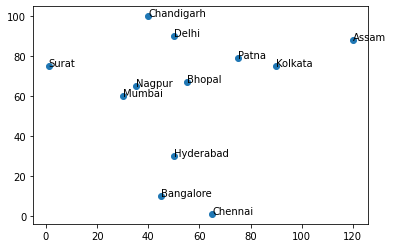

In [ ]:
plt.scatter(airports_df.X,airports_df.Y)
for i,j in enumerate(airports_df.City):
    plt.annotate(j, (airports_df.X[i],airports_df.Y[i]))

In [ ]:
distance = np.zeros((airports_df.shape[0],airports_df.shape[0]), dtype = "int32")
for i in range(airports_df.shape[0]):
    distance[i] = np.sqrt(np.square(np.array(airports_df.X[i]-airports_df.X)) + np.square(np.array(airports_df.Y[i]-airports_df.Y)))
distance

array([[  0,  36,  60,  90,  51,  42,  27,  29,  14,  70,  80,  23],
       [ 36,   0,  36,  68,  32,  61,  48,   7,  41,  94,  52,  25],
       [ 60,  36,   0,  32,  66,  60,  55,  38,  70,  90,  20,  37],
       [ 90,  68,  32,   0,  97,  78,  78,  70, 102, 102,  21,  66],
       [ 51,  32,  66,  97,   0,  89,  74,  35,  46, 119,  78,  54],
       [ 42,  61,  60,  78,  89,   0,  15,  55,  55,  32,  79,  35],
       [ 27,  48,  55,  78,  74,  15,   0,  42,  40,  45,  75,  23],
       [ 29,   7,  38,  70,  35,  55,  42,   0,  35,  88,  55,  20],
       [ 14,  41,  70, 102,  46,  55,  40,  35,   0,  80,  90,  36],
       [ 70,  94,  90, 102, 119,  32,  45,  88,  80,   0, 108,  68],
       [ 80,  52,  20,  21,  78,  79,  75,  55,  90, 108,   0,  57],
       [ 23,  25,  37,  66,  54,  35,  23,  20,  36,  68,  57,   0]])

In [ ]:
clusters = [[index] for i in hubs for index,j in enumerate(airports_df.City) if i==j]

def feasible_cluster(d):
    c = []
    pos = np.argsort(d)
    c.append(pos[0])
    for i in range(no_of_clusters-1):
        if d[pos[i+1]] - d[pos[0]] <= 3 :
            c.append(pos[i+1])
    return c
    

for i in range(airports_df.shape[0]):
    if airports_df.City[i] in hubs:
        continue
    else:
        d = []
        for j in clusters:
            d.append(int(distance[i][j[0]]))
        pos = np.argmin(d)
        if d[pos]<35:
            cs = feasible_cluster(d)
            for k in cs:
                clusters[k].append(i)

#airports_df["Group"] = [i for j in range(airports_df.shape[0]) for i in range(no_of_clusters) if j in clusters[i]]
airports_df["Group"] = [i for i in range(airports_df.shape[0]) ]
for i in range(airports_df.shape[0]):
    for j in range(no_of_clusters):
        if i in clusters[j]:
            airports_df["Group"][i] = j
            
#for i in range(airports_df.shape[0]):
#    if i not in clusters:
#        airports_df["Group"] = 4
print(clusters)

[[0, 8, 11], [1, 4, 7, 11], [5, 6, 9], [2, 3, 10]]


<ipython-input-8-c9b96ed5f4cd>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airports_df["Group"][i] = j


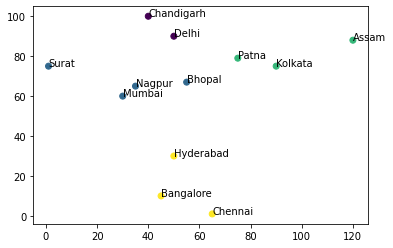

In [ ]:
plt.scatter(airports_df.X,airports_df.Y,c = np.array(airports_df["Group"])/(no_of_clusters-1))
for i,j in enumerate(airports_df.City):
    plt.annotate(j, (airports_df.X[i],airports_df.Y[i]))
plt.show();

**Fleets available at disposal**

In [ ]:
fleet =  [["A", 250, 24, 2, 1, 1], 
         ["B", 7500, 72, 4, 10, 1.05], 
         ["D", 119600, 200, 2, 10000, 0.99],
         ]
fleet_df = pd.DataFrame(data = fleet, columns = ["Type","Capacity","Range","Number","FixedCost","VariableCost"])
fleet_df

,Type,Capacity,Range,Number,FixedCost,VariableCost
0,A,250,24,2,1,1.00
1,B,7500,72,4,10,1.05
2,D,119600,200,2,10000,0.99


# Assigning Planes to each Cluster

**1.1. Fixed Flights**

a) These will be direct routes connecting the major airport of each cluster.

       (Mumbai -> Delhi), (Mumbai -> Kolkata), (Hyderabad -> Delhi) etc.

b) In case there are common nodes in between clusters that node can serve as the linking branch.

       (Mumbai -> Bhopal -> Delhi), (Delhi -> Bhopal -> Mumbai)** etc.
       
       ** Bhopal should be capable to land our biggest aircraft.

In [ ]:
#Demand on the direct flight legs

#Assuming time period is 1 for these flights

demand =  [["Mumbai", "Delhi", 65000], 
           ["Mumbai", "Kolkata", 35000], 
           ["Mumbai", "Hyderabad", 10000],
           ["Kolkata", "Delhi", 45000],
           ["Kolkata", "Mumbai", 25000],
           ["Kolkata", "Hyderabad", 5000],
           ["Hyderabad", "Delhi", 15000],
           ["Hyderabad", "Kolkata", 6000],
           ["Hyderabad", "Mumbai", 9000],
           ["Delhi", "Hyderabad", 4000],
           ["Delhi", "Kolkata", 55000],
           ["Delhi", "Mumbai", 67000]
         ]
demand_df = pd.DataFrame(data = demand, columns = ["Origin","Destination","Tonnage"])

In [ ]:
cum_dem =[]
count = 1
for i in hubs:
    for j in hubs[count:]:
        if i!=j:
            cum_dem.append([i,j,int(demand_df[demand_df.Origin == i][demand_df.Destination == j].Tonnage) + int(demand_df[demand_df.Origin == j][demand_df.Destination == i].Tonnage)])
    count = count + 1       
cum_dem_df = pd.DataFrame(data = cum_dem, columns = ["Airport1","Airport2","Tonnage"])
cum_dem_df.sort_values("Tonnage", ascending = False, inplace=True)
cum_dem_df

<ipython-input-42-6e15aa038196>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cum_dem.append([i,j,int(demand_df[demand_df.Origin == i][demand_df.Destination == j].Tonnage) + int(demand_df[demand_df.Origin == j][demand_df.Destination == i].Tonnage)])


,Airport1,Airport2,Tonnage
0,Delhi,Mumbai,132000
1,Delhi,Kolkata,90000
3,Mumbai,Kolkata,60000
2,Delhi,Hyderabad,19000
4,Mumbai,Hyderabad,19000
5,Kolkata,Hyderabad,11000


In [ ]:
mdl = Model('Best Possible Aircraft Combination')

L = range(demand_df.shape[0])

A = [(mdl.addVar(vtype = GRB.BINARY, name="A%s" % str([index])
               .format(index))) for index in L ]

B = [(mdl.addVar(vtype = GRB.BINARY, name="B%s" % str([index])
               .format(index))) for index in L ]

D = [(mdl.addVar(vtype = GRB.BINARY, name="D%s" % str([index])
               .format(index))) for index in L ]

nA = [(mdl.addVar(vtype = GRB.INTEGER, name="nA%s" % str([index])
               .format(index))) for index in L ]

nB = [(mdl.addVar(vtype = GRB.INTEGER, name="nB%s" % str([index])
               .format(index))) for index in L ]

nD = [(mdl.addVar(vtype = GRB.INTEGER, name="nD%s" % str([index])
               .format(index))) for index in L ]

fix = [(mdl.addVar(vtype = GRB.CONTINUOUS,name="fix%s" % str([i])
                   .format(i), lb = 0.0))
                   for i in L]

var = [(mdl.addVar(vtype = GRB.CONTINUOUS, name="var%s" % str([i])
                   .format(i), lb = 0.0))
                   for i in L]

mdl.update()

mdl.modelSense = GRB.MINIMIZE

mdl.setObjective(sum(mdl.getVarByName("fix"+str([i])) for i in L) 
                + sum(mdl.getVarByName("var"+str([i])) for i in L))

mdl.addConstrs( (mdl.getVarByName("nA"+str([i])) <= 2*mdl.getVarByName("A"+str([i])) for i in L), name="x")
mdl.addConstrs( (mdl.getVarByName("nB"+str([i])) <= 4*mdl.getVarByName("B"+str([i])) for i in L), name="x")
mdl.addConstrs( (mdl.getVarByName("nD"+str([i])) <= 2*mdl.getVarByName("D"+str([i])) for i in L), name="x")

mdl.addConstrs((demand_df.Tonnage[i]-
                (mdl.getVarByName("nA"+str([i]))*int(fleet_df[fleet_df.Type == "A"].Capacity)+
                mdl.getVarByName("nB"+str([i]))*int(fleet_df[fleet_df.Type == "B"].Capacity)+
                mdl.getVarByName("nD"+str([i]))*int(fleet_df[fleet_df.Type == "D"].Capacity))
                <= 0 for i in L), name = "Capacity Feasibility");

mdl.addConstrs((mdl.getVarByName("A"+str([i]))*
                (distance[k,j] - int(fleet_df[fleet_df.Type == "A"].Range)) <= 0 
                 for i in L for k in range(airports_df.shape[0]) for j in range(airports_df.shape[0])
                 if airports_df.City[k]==demand_df.Origin[i] and airports_df.City[j]==demand_df.Destination[i] ), name = "Range Feasibility");

mdl.addConstrs((mdl.getVarByName("B"+str([i]))*
                (distance[k,j] - int(fleet_df[fleet_df.Type == "B"].Range)) <= 0 
                 for i in L for k in range(airports_df.shape[0]) for j in range(airports_df.shape[0])
                 if airports_df.City[k]==demand_df.Origin[i] and airports_df.City[j]==demand_df.Destination[i] ), name = "Range Feasibility");

mdl.addConstrs((mdl.getVarByName("D"+str([i]))*
                (distance[k,j] - int(fleet_df[fleet_df.Type == "D"].Range)) <= 0 
                 for i in L for k in range(airports_df.shape[0]) for j in range(airports_df.shape[0])
                 if airports_df.City[k]==demand_df.Origin[i] and airports_df.City[j]==demand_df.Destination[i] ), name = "Range Feasibility");

mdl.addConstrs((mdl.getVarByName("nA"+str([i]))*int(fleet_df[fleet_df.Type == "A"].FixedCost) + 
                mdl.getVarByName("nB"+str([i]))*int(fleet_df[fleet_df.Type == "B"].FixedCost) + 
                mdl.getVarByName("nD"+str([i]))*int(fleet_df[fleet_df.Type == "D"].FixedCost)
                == mdl.getVarByName("fix"+str([i])) for i in L), name = "Fixed");

mdl.addConstrs((mdl.getVarByName("var"+str([i])) == (
                mdl.getVarByName("A"+str([i]))*int(fleet_df[fleet_df.Type == "A"].VariableCost) + 
                mdl.getVarByName("B"+str([i]))*int(fleet_df[fleet_df.Type == "B"].VariableCost) + 
                mdl.getVarByName("D"+str([i]))*int(fleet_df[fleet_df.Type == "D"].VariableCost))*demand_df.Tonnage[i]  for i in L), name = "Variable");

mdl.update()
mdl.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 108 rows, 96 columns and 228 nonzeros
Model fingerprint: 0x0eaf4ccc
Variable types: 24 continuous, 72 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+03, 7e+04]
Presolve removed 108 rows and 96 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 104050 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.040500000000e+05, best bound 1.040500000000e+05, gap 0.0000%


In [ ]:
print("Which planes are the best for the given cargo demand?\n")
for i in L:
    print(i,"th load going from",demand_df.Origin[i],"to",demand_df.Destination[i]," :","\t",int(mdl.getVarByName("nA"+str([i])).x),int(mdl.getVarByName("nB"+str([i])).x),int(mdl.getVarByName("nD"+str([i])).x))

Which planes are the best for the given cargo demand?

0 th load going from Mumbai to Delhi  : 	 0 0 1
1 th load going from Mumbai to Kolkata  : 	 0 0 1
2 th load going from Mumbai to Hyderabad  : 	 0 0 1
3 th load going from Kolkata to Delhi  : 	 0 0 1
4 th load going from Kolkata to Mumbai  : 	 0 0 1
5 th load going from Kolkata to Hyderabad  : 	 0 1 0
6 th load going from Hyderabad to Delhi  : 	 0 0 1
7 th load going from Hyderabad to Kolkata  : 	 0 1 0
8 th load going from Hyderabad to Mumbai  : 	 0 2 0
9 th load going from Delhi to Hyderabad  : 	 0 1 0
10 th load going from Delhi to Kolkata  : 	 0 0 1
11 th load going from Delhi to Mumbai  : 	 0 0 1


Analysis and Experience tells the planner that the planes **Type D** will suffice the direct flights as the Hyderabad originating flights can be carried together in the belly of **Type D**.

In [ ]:
d_plane =  [[1,"D","Mumbai"], 
            [2,"D","Kolkata"],
            [3,"B","Hyderabad"],
            [4,"B","Mumbai"]
           ]
d_plane_df = pd.DataFrame(data = d_plane, columns = ["Index","type","Origin"])
d_plane_df

,Index,type,Origin
0,1,D,Mumbai
1,2,D,Kolkata
2,3,B,Hyderabad
3,4,B,Mumbai


Generating possible routes for the direct routes

a) Minimising Costs

b) Near equal utilisation of each aircraft

**Experience tells that each plan can run at max 'N' trips a day**

In [ ]:
N = int(input("How many trips a plane can make in a day ? "))

How many trips a plane can make in a day ? 5


**Step: Develop sub-clusters such that each demand can be satisfied.**

In [ ]:
no_sub_clusters = int(demand_df.shape[0]/N)
no_sub_clusters

2

In [ ]:
hubs_index = [i for i in range(airports_df.shape[0]) if airports_df.City[i] in hubs]

max_itinaries = 2

def cargo_flow_path(b,ix,orig,dest):
    list = []
    def feasible(orig,dest,j):
        e = 0.75 #eccentricity
        a = distance[orig,dest]/(2*e)
        b = np.sqrt(a*a-(a*e)**2)
        xx = airports_df.X[j] - (airports_df.X[orig]+airports_df.X[dest])/2
        yy = airports_df.Y[j] - (airports_df.Y[orig]+airports_df.Y[dest])/2
        s = (xx/a)**2 + (yy/b)**2
        if s<=1:
            return True
        else:
            return False
    
    def f(lt,ix):
        if ix == 0:
            list.append(lt.copy()) 
        else :
            for j in b:
                if len(lt) == 0 and feasible(orig,dest,j):
                    lt2 = lt.copy()
                    lt2.append(j)
                    f(lt2.copy(),ix-1)
                    
                elif len(lt) > 0 and j not in lt and feasible(airports_df.City[lt[-1]],dest,j):
                    lt2 = lt.copy()
                    lt2.append(j)
                    f(lt2.copy(),ix-1)

    f(list.copy(),ix)
    return list
                

def cargo_path_generator(index):
    orig = [i for i in hubs_index if demand_df.Origin[index] == airports_df.City[i]] 
    dest = [j for j in hubs_index if demand_df.Destination[index] == airports_df.City[j]]
    b = [i for i in hubs_index if i not in orig and i not in dest]
    paths = []
    paths.append([orig[0],dest[0]])
    for i in range(min(max_itinaries,len(hubs_index)-2)):
        if i==0:
            continue
        else:
            P = cargo_flow_path(b,i,orig[0],dest[0])
            for p in P:
                list = []
                list.append(orig[0])
                for z in p:
                    list.append(z)
                list.append(dest[0])
                paths.append(list)
            
    return paths

paths = [[] for i in range(demand_df.shape[0])]
for i in range(demand_df.shape[0]):
    paths[i] = cargo_path_generator(i)


In [ ]:
paths

[[[1, 0]],
 [[1, 5], [1, 0, 5]],
 [[1, 2]],
 [[5, 0]],
 [[5, 1], [5, 0, 1]],
 [[5, 2]],
 [[2, 0], [2, 1, 0]],
 [[2, 5]],
 [[2, 1]],
 [[0, 2], [0, 1, 2]],
 [[0, 5]],
 [[0, 1]]]

Assumption: Only cyclic flight routes are considered.

**1. Combine all single-legged options together to form the longest possible chain/cycle. (Category A)**

**2. Check the feasibility of the multi-legged routes with respect to the biggest aircraft possible on that route. If not, reject them. If for such an od pair no multi-legged alternative exists add the direct link. (Category A)**

**3. See if the multi-legged paths are reflected in the chains. If not add them at the necessary locations. (Category B)**

**4. Generate "N" sub-clusters around the feasible multi-legged chains keeping in mind the maximum number of trips that can be covered.**

For our generated paths:

a) 1 <-> 0 <-> 5 <-> 2 <-> 1

b) Path (5->0->1) is not feasible as cumulative demand across 5->0 and 5->1 exceeds the capacity of Type D plane.
   i. (1 <-> {0) <-> 5} <-> 2 <-> 1 <-> 5
   
c) Done.

d) Sub-cluster 1: 0 <-> 1 and 0 <-> 5 with no interchangeability between places

   Sub-cluster 2: 5 <-> 2 <-> 1 <-> 5 with allowed interchangeability between places
   
For generating aircraft routes:

a) If origin of any plane lies in the sub-cluster, assign that plane to that cluster. Route begins with the origin and can be generated on the basis of the airports in that sub-cluster and its interchangeability condition.

Objective is to find routes with the **minimum legs** and the most **cyclical**.

For sub-cluster 1 if plane is originally at Node 0 the possible routes are 0->1->0->5->0 or 0->5->0->1->0, the other possibilities are not economical or are infeasible. If the origin was at node 1 the routes could have been 1->0->5->0->1, the other possibilities being uneconomical or infeasible. 

For sub-cluster 2 if plane is originally at Node 5 the routes can be 5->(A)->(A')->(A)->5 where A can be anything between [1,2].

**Generate all the routes for the two Type D planes utilised in the direct flights.**

**For a T-day period copy the routes T times.**

**Assigning flights to local clusters**

**2.1. Local Flights**

a) All minor airports will be shipping cargo to be sent to other clusters to its base.

       (Nagpur -> Mumbai), (Bangalore -> Hyderabad), (Bhopal -> Delhi) etc.

b) There can be interlinkages as well between the minor airports of each cluster.

       (Nagpur <-> Surat), (Chennai -> Bangalore) etc.
       
c) There can be external flights in this scenario.

**Generating the cargo routes**

For example, (Surat -> Mumbai -> Kolkata -> Assam)

For special cases like Bhopal's location we may even have, (Mumbai/Delhi -> Bhopal -> Kolkata -> Assam)

**The planner is required to allocate the airplanes to each cluster's base through his experience.**

**The cluster is also divided into sub-clusters with the right plane assigned to them.**

**Process 1: Identify the flights that can be outsourced. Generate two sets of routes. One without these and one with these**

**Process 2: Segregate the everyday flights and periodic flights.**

**Process 3: For everyday cases compute all the possible routes and to these routes add periodic flight constituent airport/airports at all places.**

Everyday route is (Hyderabad->Bangalore->Chennai->Hyderabad)

The possible routes for a periodic airport becomes (Hyderabad->X->Bangalore->Chennai->Hyderabad), (Hyderabad->Bangalore->X->Chennai->Hyderabad), (Hyderabad->Bangalore->Chennai->X->Hyderabad)

**Process 4: Repeat the routes for T-day frame.Use best judgement to modify the routes as and when necessary based on sudden demand.**

# Now for each individual aircraft we have a set of possible routes and for each cargo a set of possible paths. Additionally we have the information regarding the external flights and the demand forecasts.

**Run basic formulation to select routes just on the objective of minimising route costs.**

**Incase of repeating patterns of demand run the model for the smallest time frame that covers all patterns**

In [ ]:
#L = load_indexes
#S_len[i] = indexes of paths of each ith cargo
#S[i] = set of all cargo paths of ith cargo
#R_len[i] = indexes of routes of each ith plane
#R[i] = set of all routes of ith plane
#N = set of owned planes
#E = set of external flights

mdl = Model('Route Selector')

P = [(mdl.addVar(vtype = GRB.BINARY, name="P%s" % str([index,k])
               .format(index,k))) for index in L for k in S_len[index-1]]

B = [(mdl.addVar(vtype = GRB.BINARY, name="B%s" % str([i,u])
                .format(i,u))) 
                     for i in N for u in route_len[i-1]]

X = [(mdl.addVar(vtype = GRB.BINARY, lb = 0.0, name="X%s" % str([i,index,k,leg])
                 .format(i,index,k,leg))) 
                     for index in L for i in N for k in S_len[index-1] for leg,_ in enumerate(S[index-1][k][:-1])] 

Z = [(mdl.addVar(vtype = GRB.BINARY, lb = 0.0, name="Z%s" % str([j,index,k,leg])
                 .format(j,index,k,leg))) 
                     for index in L for j in E for k in S_len[index-1] for leg,_ in enumerate(S[index-1][k][:-1])] 

F = [(mdl.addVar(vtype = GRB.BINARY, name="F%s" % str([i,u,leg,index,k,leg_c])
                .format(i,u,leg,index,k,leg_c))) 
                     for i in N for u in route_len[i-1] for leg,_ in enumerate(routes[i-1][u][:-1])
                     for index in L for k in S_len[index-1] for leg_c,_ in enumerate(S[index-1][k][:-1])] 

Ctrf = [(mdl.addVar(vtype = GRB.CONTINUOUS, name="Ctrf%s" % str([index])
                   .format(index), lb = 0.0))
                   for index in L]

Cfix = [(mdl.addVar(vtype = GRB.CONTINUOUS,name="Cfix%s" % str([i])
                   .format(i), lb = 0.0))
                   for i in N]

Cvar = [(mdl.addVar(vtype = GRB.CONTINUOUS, name="Cvar%s" % str([i])
                   .format(i), lb = 0.0))
                   for i in N]

Cext = [(mdl.addVar(vtype = GRB.CONTINUOUS, name="Cext%s" % str([j])
                   .format(j), lb = 0.0))
                   for j in E]

mdl.update()

mdl.modelSense = GRB.MINIMIZE

mdl.setObjective(sum(mdl.getVarByName("Ctrf"+str([index])) for index in L)
                + sum(mdl.getVarByName("Cfix"+str([i])) for i in N) 
                + sum(mdl.getVarByName("Cvar"+str([i])) for i in N)
                + sum(mdl.getVarByName("Cext"+str([j])) for j in E))

In [ ]:
#CONSTRAINTS FOR BINARY VARIABLES AND INITIALISATIONS

mdl.addConstrs((quicksum(mdl.getVarByName("P"+str([index,k])) 
                    for k in S_len[index-1]) == 1 for index in L), name = "One_Path");

mdl.addConstrs((quicksum(mdl.getVarByName("B"+str([i,u])) 
                    for u in route_len[i-1]) <= 1 for i in N), name = "At_max_One_Route");

mdl.addConstrs(((
    sum(mdl.getVarByName("X"+str([i,index,k,leg])) for i in N) + 
    sum(mdl.getVarByName("Z"+str([j,index,k,leg])) for j in E)) 
    == mdl.getVarByName("P"+str([index,k]))
        for index in L for k in S_len[index-1] for leg,_ in enumerate(S[index-1][k][:-1]) ), name = "Only_one_plane_or_no_plane"); 


mdl.addConstrs((
    mdl.getVarByName("X"+str([i,index,k,leg]))
    <= sum(mdl.getVarByName("B"+str([i,u])) for u in route_len[i-1])
        for index in L for i in N for k in S_len[index-1] for leg,_ in enumerate(S[index-1][k][:-1]) ), name = "Route_has_to_be_Selected");

#CARGO CAN JUMP SHIP ONLY AT TRANSFER HUBS

mdl.addConstrs((
    mdl.getVarByName("X"+str([i,index,k,leg])) 
    <= mdl.getVarByName("X"+str([i,index,k,leg+1]))
    for i in N for index in L for k in S_len[index-1] for leg,_ in enumerate(S[index-1][k][:-2]) 
    if S[index-1][k][leg+1] not in HUB), name = "Transfer_Hubs");

#EXTERNAL FLIGHTS MATCH THE REQUIREMENTS OF THE CARGO

mdl.addConstrs((
    mdl.getVarByName("Z"+str([j,index,k,leg])) <= 1
    for j in E for index in L for k in S_len[index-1] for leg,_ in enumerate(S[index-1][k][:-1]) 
    if ext[j-1][7] == S[index-1][k][leg] and ext[j-1][8] == S[index-1][k][leg+1]), 
    name = "Ext_legs_match");

mdl.addConstrs((
    sum(mdl.getVarByName("Z"+str([j,index,k,leg])) * 
    load[index-1][3] for index in L for k in S_len[index-1] for leg,_ in enumerate(S[index-1][k][:-1]))
    <= ext[j-1][3] 
    for j in E), name = "Weight_constraint_ext");

#ATTACHING FLIGHT ROUTES AND CARGO FLOW PATHS IN A VARIABLE

mdl.addConstrs((
    sum(
        mdl.getVarByName("F"+str([i,u,leg,index,k,leg_c])) 
        for leg,_ in enumerate(routes[i-1][u][:-1]) 
        if S[index-1][k][leg_c] == routes[i-1][u][leg] and S[index-1][k][leg_c+1] == routes[i-1][u][leg+1]
    )  == 
    mdl.getVarByName("B" + str([i,u])) * 
    mdl.getVarByName("X"+str([i,index,k,leg_c]))
    for i in N for u in route_len[i-1]
    for index in L for k in S_len[index-1] for leg_c,_ in enumerate(S[index-1][k][:-1]) ),name = "F1");

mdl.addConstrs((
    mdl.getVarByName("F"+str([i,u,leg2,index,k,leg_c2])) <= 1 - mdl.getVarByName("F"+str([i,u,leg1,index,k,leg_c1]))
    
    for i in N for u in route_len[i-1] 
    for leg1,_ in enumerate(routes[i-1][u][:-1]) for leg2,_ in enumerate(routes[i-1][u][:-1]) 
    for index in L for k in S_len[index-1] 
    for leg_c1,_ in enumerate(S[index-1][k][:-1]) for leg_c2,_ in enumerate(S[index-1][k][:-1]) if leg1>leg2 and leg_c1<leg_c2), name = "F4");

#WEIGHT OF CARGO IS NOT MORE THAN FLIGHT CAPACITY

mdl.addConstrs((
    sum(
        mdl.getVarByName("F"+str([i,u,leg,index,k,leg_c])) * 
        load[index-1][3] 
        for index in L for k in S_len[index-1] for leg_c,_ in enumerate(S[index-1][k][:-1])
    )
    <= fleet[i-1][3] 
     for i in N for u in route_len[i-1] for leg,_ in enumerate(routes[i-1][u][:-1])), name = "Weight_of_fleet");

#Transfering Costs
mdl.addConstrs((mdl.getVarByName("Ctrf"+str([index]))
               ==sum(mdl.getVarByName("X"+str([i,index,k,leg]))
                       * mdl.getVarByName("X"+str([g,index,k,leg+1]))
                       * (dataset_airports[str(fleet[i-1][2])][S[index-1][k][leg+1]-1]+dataset_airports[str(fleet[g-1][2])][S[index-1][k][leg+1]-1])
                       for k in S_len[index-1] for leg,_ in enumerate(S[index-1][k][:-2]) for i in N for g in N if i!=g) 
                for index in L ),name="Transfer_costs");

#Fixed Costs of Routes
mdl.addConstrs((mdl.getVarByName("Cfix"+str([i])) == 
                sum(mdl.getVarByName("B"+str([i,u])) * 
               (sum(dataset_airports[str(routes[i-1][u][leg])][routes[i-1][u][leg+1]-1]
                   *fleet[i-1][11]    
               for leg,_ in enumerate(routes[i-1][u][:-1])) + fleet[i-1][10]) for u in route_len[i-1]) for i in N ), name = "fixed_costs");

#Variable Costs of Routes
mdl.addConstrs((mdl.getVarByName("Cvar"+str([i])) ==
                sum(mdl.getVarByName("X"+str([i,index,k,leg])) * 
                    fleet[i-1][17] * load[index-1][3] * dataset_airports[str(S[index-1][k][leg])][S[index-1][k][leg+1]-1] 
                  for index in L for k in S_len[index-1] for leg,_ in enumerate(S[index-1][k][:-1])) for i in N ), name = "variable_costs");

#Costs for external ships
mdl.addConstrs((mdl.getVarByName("Cext"+str([j])) == sum(mdl.getVarByName("Z"+str([j,index,k,leg])) for index in L for k in S_len[index-1] for leg,_ in enumerate(S[index-1][k][:-1]))*ext[j-1][4]+
               sum(mdl.getVarByName("Z"+str([j,index,k,leg]))*ext[j-1][6]*load[index-1][3] 
                for index in L for k in S_len[index-1] for leg,_ in enumerate(S[index-1][k][:-1])) for j in E), name = "External_costs");


In [ ]:
mdl.params.NonConvex = 2
mdl.update()
mdl.optimize()

**Retrieving Solutions**

After optimization has completed, you can retrieve solutions from the solution pool using a few parameters and attributes. The SolCount attribute indicates how many solutions were retained by the MIP solver. The best solution can always be obtained through the X attribute. Sub-optimal solutions can be obtained by first setting the SolutionNumber parameter and then querying the Xn attribute to obtain the solution or the PoolObjVal attribute to obtain the objective value for the corresponding solution.

**Process:**

 a) We have the solution space for routes.

 b) Retrieve the best optimal/sub-optimal solution routes.

 c) Run the original formulation to check if it is feasible time and maintenance wise across the entire Time period considered.

 d) If optimal stop otherwise remove this solution and start again from step b)